<a href="https://colab.research.google.com/github/Rochdy-max/traffic-flow-prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essential libraries importing

In [66]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import sklearn

# Data acquisition

Target files are the ones about weeks 1 to 9 of 2024

In [67]:
from google.colab import drive
from pathlib import Path

drive_mount_path = "/content/drive"

if not Path(drive_mount_path).exists():
  drive.mount(drive_mount_path)

In [68]:
from google.colab import userdata

data_path = userdata.get('data_path')

# Load data

In [69]:
%ls "{data_path}"

trafic_capteurs_2024_W01_20240101_20240108.txt
trafic_capteurs_2024_W02_20240108_20240115.txt
trafic_capteurs_2024_W03_20240115_20240122.txt
trafic_capteurs_2024_W04_20240122_20240129.txt
trafic_capteurs_2024_W05_20240129_20240201.txt
trafic_capteurs_2024_W05_20240201_20240205.txt
trafic_capteurs_2024_W06_20240205_20240212.txt
trafic_capteurs_2024_W07_20240212_20240219.txt
trafic_capteurs_2024_W08_20240219_20240226.txt
trafic_capteurs_2024_W09_20240226_20240301.txt


Let's load week 1 data

In [70]:
w1_df = pd.read_csv(f"{data_path}/trafic_capteurs_2024_W01_20240101_20240108.txt", sep=";")

print(w1_df.shape, "\n")
w1_df.head()

(555240, 12) 



,iu_ac,libelle,iu_nd_amont,libelle_nd_amont,iu_nd_aval,libelle_nd_aval,t_1h,q,k,etat_trafic,etat_barre,dessin
0,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2024-01-01 01:00:00,151.0,0.94556,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
1,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2024-01-01 02:00:00,182.0,1.20833,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
2,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2024-01-01 03:00:00,183.0,1.54611,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
3,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2024-01-01 04:00:00,158.0,0.84889,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
4,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2024-01-01 05:00:00,115.0,0.71278,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."


Here is the data description

- *iu_ac* : Unique identifier for the traffic data arc
- *libelle* : Label of the track or track section modeled by the arc
- *iu_nd_amont* : Unique identifier of the upstream node of the arc
- *libelle_nd_amont* : Label of the upstream node of the arc
- *iu_nd_aval* : Identifier of the downstream node of the arc
- *libelle_nd_aval* : Label of the downstream node of the arc
- *t_1h* : Time stamp (end of processing period) in ISO format: YYYY-MM-DD HH:MM:SS
- *q* : Traffic flow (number of vehicles counted during the hour)
- *k* : Occupancy rate (as a percentage of time the measuring station is occupied by vehicles per hour). Based on this value, we can qualify traffic state at the measuring point
  + $0\% \le k \lt 15\% \rightarrow$ fluid  
  + $15\% \le k \lt 30\% \rightarrow$ presaturated  
  + $30\%  \le k \lt 50\% \rightarrow$ saturated  
  + $50\%  \le k \rightarrow$ blocked  
- *etat_trafic* : Traffic state qualification
  + 0: unknown
  + 1: fluid
  + 2: presaturated
  + 3: saturated
  + 4: blocked
- *etat_barre* : Open or closed state (crossed out, unknown, or invalid) for
arc circulation
  + 0: unknown
  + 1: open
  + 2: closed
  + 3: invalid
- *dessin* : Schematic drawing of the arc for the corresponding identifier "iu_ac" and timestamp "t_1h"

# Data overview

In [71]:
w1_df.dtypes

,0
iu_ac,int64
libelle,object
iu_nd_amont,int64
libelle_nd_amont,object
iu_nd_aval,int64
libelle_nd_aval,object
t_1h,object
q,float64
k,float64
etat_trafic,int64


In [72]:
w1_df["t_1h"] = pd.to_datetime(w1_df["t_1h"])

w1_df["t_1h"].head()

,t_1h
0,2024-01-01 01:00:00
1,2024-01-01 02:00:00
2,2024-01-01 03:00:00
3,2024-01-01 04:00:00
4,2024-01-01 05:00:00


In [73]:
w1_df.describe()

,iu_ac,iu_nd_amont,iu_nd_aval,t_1h,q,k,etat_trafic,etat_barre
count,555240.000000,555240.000000,555240.000000,555240,260251.000000,265756.000000,555240.000000,555240.000000
mean,3665.745537,1817.121331,1814.705295,2024-01-04 12:29:59.999999744,623.583641,5.926950,0.534529,2.768945
min,1.000000,0.000000,0.000000,2024-01-01 01:00:00,0.000000,0.000000,0.000000,1.000000
25%,1248.000000,578.000000,579.000000,2024-01-02 18:45:00,134.000000,1.350000,0.000000,3.000000
50%,4542.000000,2315.000000,2315.000000,2024-01-04 12:30:00,289.000000,3.302780,0.000000,3.000000
75%,5589.000000,2864.000000,2861.000000,2024-01-06 06:15:00,564.000000,7.148890,1.000000,3.000000
max,7231.000000,3740.000000,3740.000000,2024-01-08 00:00:00,7914.000000,96.118330,4.000000,3.000000
std,2332.511268,1202.643205,1199.293495,NaN,1078.200166,7.937559,0.626988,0.626147


In [74]:
# Basic statistics
print(f"Time range: <{w1_df['t_1h'].min()}> to <{w1_df['t_1h'].max()}>", "\n")
print(f"Number of unique arcs: {w1_df['iu_ac'].nunique()}", "\n")

Time range: <2024-01-01 01:00:00> to <2024-01-08 00:00:00> 

Number of unique arcs: 3305 



In [75]:
# Record distribution per arc
w1_df['iu_ac'].value_counts().describe()

,count
count,3305.0
mean,168.0
std,0.0
min,168.0
25%,168.0
50%,168.0
75%,168.0
max,168.0


All arcs appear the same number of times for this week dataset : 168.

## Arcs selection

In [76]:
w1_df['etat_trafic_inconnu'] = (w1_df["etat_trafic"] == 0).astype(int)
w1_df['missing_q'] = (w1_df["q"].isna()).astype(int)

In [77]:
# Arcs with the least number of `Unknown` label for traffic state
arcs_df = (
    w1_df
    .groupby('iu_ac')
    .agg(
        {
            "libelle": "first",
            "etat_trafic_inconnu": "sum",
            "missing_q": "sum",
        }
    )
    .sort_values("etat_trafic_inconnu")
)

arcs_df.head()


,libelle,etat_trafic_inconnu,missing_q
iu_ac,,,
1343,Av_Republique,0,168
1345,Bd_Voltaire,0,0
1346,Bd_Voltaire,0,0
1347,Bd_Voltaire,0,0
1348,Bd_Voltaire,0,0


<Axes: xlabel='missing_q', ylabel='Count'>

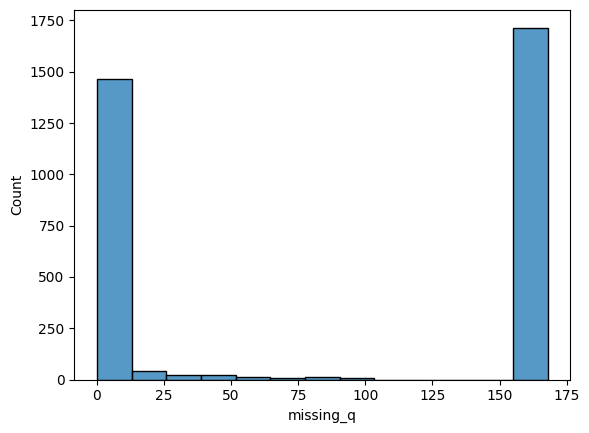

In [78]:
sns.histplot(arcs_df["missing_q"])

Let's keep only the arcs with no missing `q` value

In [79]:
arcs_df = arcs_df[arcs_df["missing_q"] == 0]

print(arcs_df.shape)
arcs_df.head()

(927, 3)


,libelle,etat_trafic_inconnu,missing_q
iu_ac,,,
1345,Bd_Voltaire,0,0
1346,Bd_Voltaire,0,0
1347,Bd_Voltaire,0,0
1348,Bd_Voltaire,0,0
1349,Bd_Voltaire,0,0


In [80]:
n_arcs = 10

Since a single track (libelle) can have multiple arcs, let's choose arcs belonging to different tracks.

In [81]:
selected_arcs_df = arcs_df.drop_duplicates(("libelle")).head(n_arcs)

selected_arcs_df

,libelle,etat_trafic_inconnu,missing_q
iu_ac,,,
1345,Bd_Voltaire,0,0
1395,Pyrenees,0,0
1397,Av_Republique,0,0
6793,Quai_d'Orsay,0,0
6811,Alain,0,0
6813,Invalides_Gallieni,0,0
6815,Av_des_Champs_Elysees,0,0
6818,Bd_Malesherbes,0,0
6996,Belleville,0,0


In [82]:
selected_arcs = list(selected_arcs_df.index)
selected_arcs

[1345, 1395, 1397, 6793, 6811, 6813, 6815, 6818, 6996, 6997]

In [83]:
w1_df.drop(columns=["etat_trafic_inconnu", "missing_q"], inplace=True)

In [84]:
df = w1_df[w1_df["iu_ac"].isin(selected_arcs)]

for w_f in os.scandir(data_path):
    print(w_f.name, end=":")
    if w_f.name.startswith("trafic_capteurs_2024_W01"):
        print(" skipped")
        continue
    w_df = pd.read_csv(os.path.join(w_f), sep=";")
    df = pd.concat([df, w_df[w_df["iu_ac"].isin(selected_arcs)]])
    print(" loaded")

trafic_capteurs_2024_W03_20240115_20240122.txt: loaded
trafic_capteurs_2024_W02_20240108_20240115.txt: loaded
trafic_capteurs_2024_W05_20240201_20240205.txt: loaded
trafic_capteurs_2024_W05_20240129_20240201.txt: loaded
trafic_capteurs_2024_W04_20240122_20240129.txt: loaded
trafic_capteurs_2024_W06_20240205_20240212.txt: loaded
trafic_capteurs_2024_W07_20240212_20240219.txt: loaded
trafic_capteurs_2024_W09_20240226_20240301.txt: loaded
trafic_capteurs_2024_W08_20240219_20240226.txt: loaded
trafic_capteurs_2024_W01_20240101_20240108.txt: skipped


In [85]:
df = df.set_index(pd.RangeIndex(df.shape[0]))
df = df.drop(columns=["dessin"])

df["t_1h"] = pd.to_datetime(df["t_1h"])

print(df.shape, "\n")
df.head()

(14400, 11) 



,iu_ac,libelle,iu_nd_amont,libelle_nd_amont,iu_nd_aval,libelle_nd_aval,t_1h,q,k,etat_trafic,etat_barre
0,6996,Belleville,3626,Belleville-Dury Vasselon,810,Belleville-Haxo,2024-01-01 01:00:00,261.0,6.01500,1,3
1,6996,Belleville,3626,Belleville-Dury Vasselon,810,Belleville-Haxo,2024-01-01 02:00:00,293.0,25.25222,2,3
2,6996,Belleville,3626,Belleville-Dury Vasselon,810,Belleville-Haxo,2024-01-01 03:00:00,303.0,24.08445,2,3
3,6996,Belleville,3626,Belleville-Dury Vasselon,810,Belleville-Haxo,2024-01-01 04:00:00,269.0,24.86556,2,3
4,6996,Belleville,3626,Belleville-Dury Vasselon,810,Belleville-Haxo,2024-01-01 05:00:00,247.0,19.10778,2,3


In [86]:
# df["etat_trafic_inconnu"] = (df["etat_trafic"] == 0).astype(int)
# df['missing_q'] = (df["q"].isna()).astype(int)

In [87]:
# (
#     df
#     .groupby('iu_ac')
#     .agg(
#         {
#             "libelle": "first",
#             "etat_trafic_inconnu": "sum",
#             "missing_q": "sum",
#         }
#     )
#     .sort_values("etat_trafic_inconnu")
# ).reset_index()

In [88]:
df.describe()

,iu_ac,iu_nd_amont,iu_nd_aval,t_1h,q,k,etat_trafic,etat_barre
count,14400.000000,14400.000000,14400.000000,14400,12503.00000,12498.000000,14400.000000,14400.000000
mean,5218.000000,2615.600000,1581.800000,2024-01-31 00:30:00.000000256,353.03959,6.780660,1.020417,2.998472
min,1345.000000,686.000000,138.000000,2024-01-01 01:00:00,9.00000,0.000000,0.000000,2.000000
25%,1397.000000,749.000000,702.000000,2024-01-16 00:45:00,169.50000,1.727780,1.000000,3.000000
50%,6812.000000,3326.500000,770.000000,2024-01-31 00:30:00,307.00000,3.425560,1.000000,3.000000
75%,6818.000000,3532.000000,3149.000000,2024-02-15 00:15:00,477.00000,7.700143,1.000000,3.000000
max,6997.000000,3627.000000,3415.000000,2024-03-01 00:00:00,1323.00000,85.123340,4.000000,3.000000
std,2514.333355,1249.141865,1229.531595,NaN,246.42340,8.461663,0.584424,0.039058


## Traffic state analysis

In [89]:
traffic_state_label = ["Unknown", "Fluid", "Presaturated", "Saturated", "Blocked"]

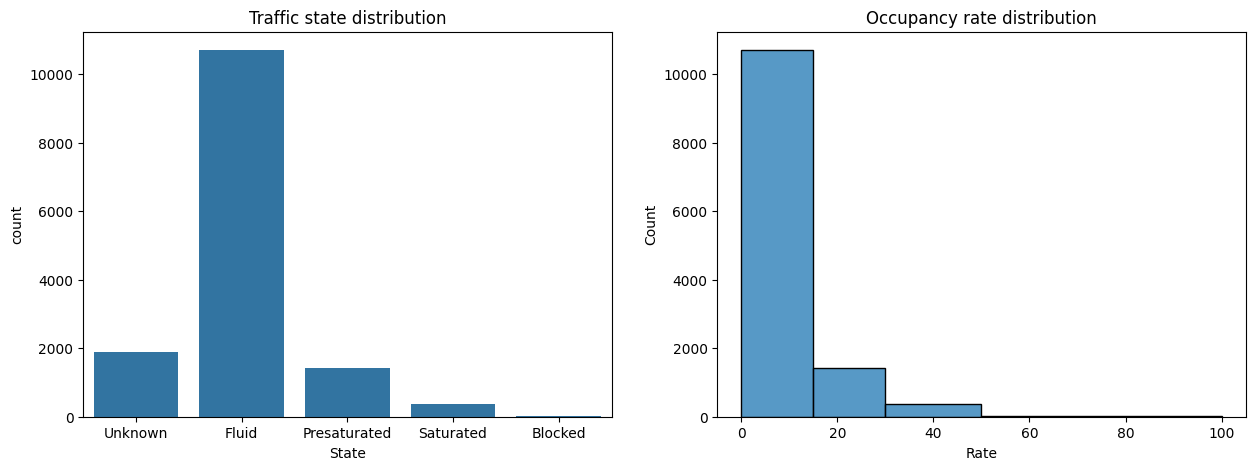

In [90]:
# Traffic state and occupancy rate distribution
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.barplot(x=traffic_state_label, y=df['etat_trafic'].value_counts().sort_index())
plt.title("Traffic state distribution")
plt.xlabel("State")

plt.subplot(122)
sns.histplot(df, x="k", bins=[0, 15, 30, 50, 100])
plt.title("Occupancy rate distribution")
plt.xlabel("Rate")

plt.show()

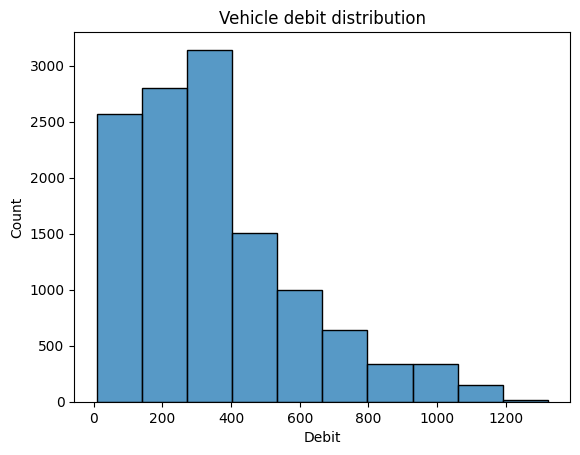

In [91]:
sns.histplot(df, x="q", bins=10)

plt.title("Vehicle debit distribution")
plt.xlabel("Debit")
plt.show()

In [119]:
open_closed_state_label = ["Unknown", "Open", "Closed", "Invalid"]

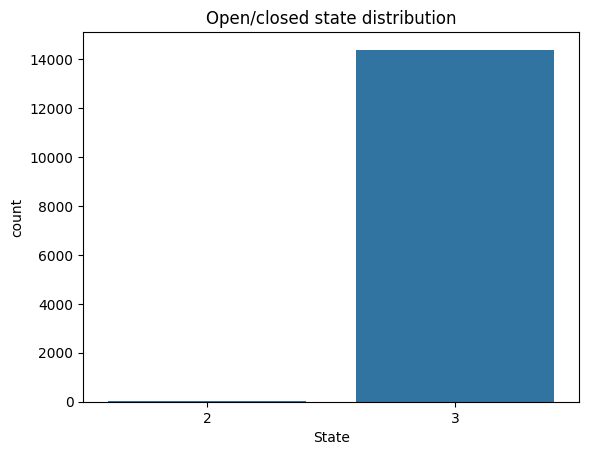

In [126]:
sns.barplot(df['etat_barre'].value_counts())
plt.title("Open/closed state distribution")
plt.xlabel("State")
plt.show()


# Temporal patterns

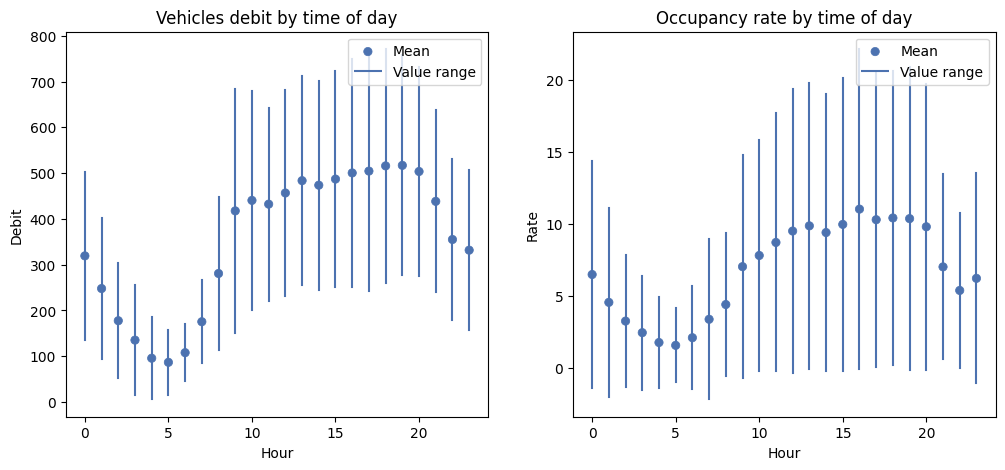

In [92]:
plt.figure(figsize=(12, 5))

# Vehicles debit `q` by time of day
ax = plt.subplot(121)
p = so.Plot(df, x=df["t_1h"].dt.hour, y="q")
p = p.add(so.Dot(), so.Agg("mean"))
p = p.add(so.Range(), so.Est(errorbar="sd"))

p = p.label(title="Vehicles debit by time of day")

p.on(ax).plot()
ax.legend(["Mean", "Value range"])
ax.set_xlabel("Hour")
ax.set_ylabel("Debit")


# Occupancy rate by time of day
ax = plt.subplot(122)
p = so.Plot(df, x=df["t_1h"].dt.hour, y="k")
p = p.add(so.Dot(), so.Agg("mean"))
p = p.add(so.Range(), so.Est(errorbar="sd"))

p = p.label(title="Occupancy rate by time of day")

p.on(ax).plot()
ax.legend(["Mean", "Value range"])
ax.set_xlabel("Hour")
ax.set_ylabel("Rate")

plt.show()

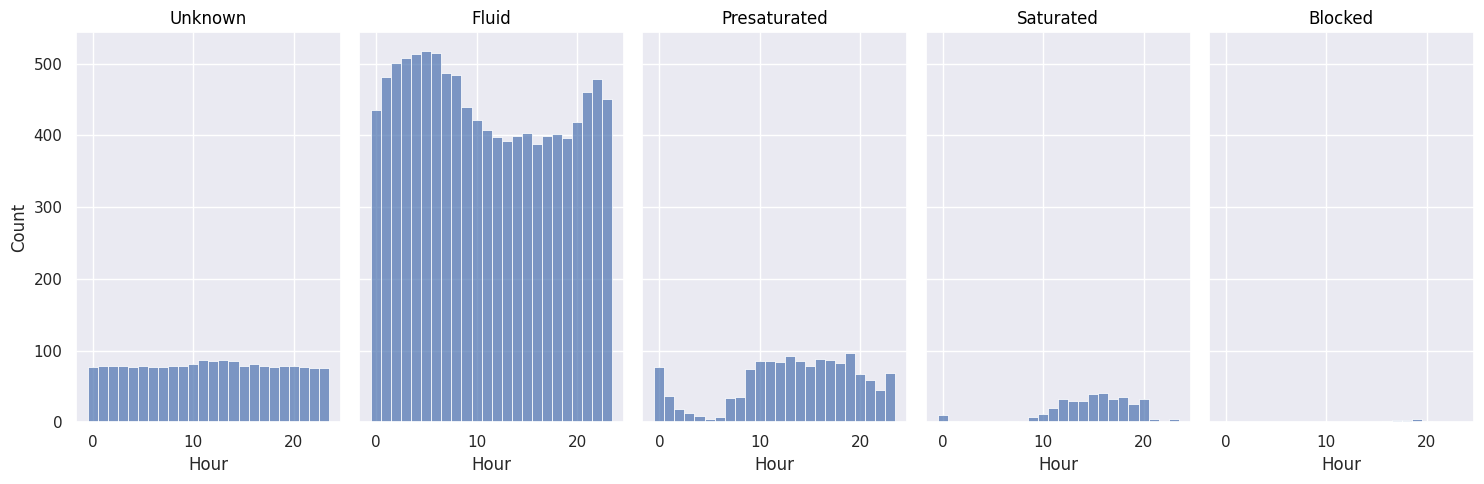

In [93]:
# Traffic state distribution by time of day
p = so.Plot(df, x=df["t_1h"].dt.hour)
p = p.facet("etat_trafic")
p = p.add(so.Bars(), so.Count())

p = p.layout(size=(15, 5))
p = p.label(title=lambda x: traffic_state_label[int(x)], x="Hour", y="Count")

p.show()

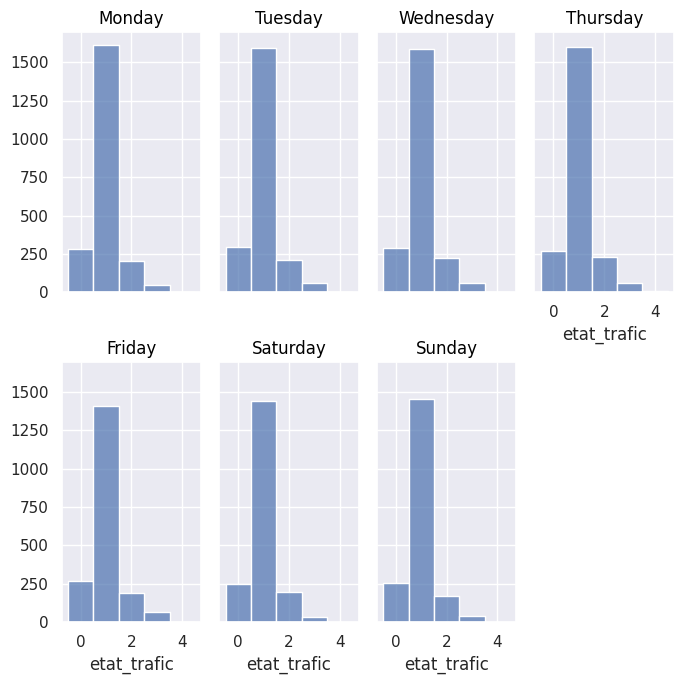

In [118]:
# Day-based comparison
p = so.Plot(df, x="etat_trafic")
p = p.facet(df["t_1h"].dt.day_name(), wrap=4)
p = p.add(so.Bars(), so.Count())
p = p.layout(size=(7, 7))
p.show()

# Null handling

In [95]:
# Missing values
df.isna().sum()

,0
iu_ac,0
libelle,0
iu_nd_amont,0
libelle_nd_amont,0
iu_nd_aval,0
libelle_nd_aval,0
t_1h,0
q,1897
k,1902
etat_trafic,0
